In [5]:
## Importing the necesssary Libraries

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import psycopg2 as pg2
import datetime as dt
# package used for converting the data into datetime format
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [7]:
##Establish connection to the postgres database

In [8]:
conn= pg2.connect('dbname = Amazon user= postgres password =data host= 127.0.0.1')
cur=conn.cursor()
df_raw = pd.read_sql_query('select * from public."keepa"', conn)

In [9]:
#Check the dimension of the raw data to see if its properly imported
print('Starting size of our Dataset ')
df_raw.shape

Starting size of our Dataset 


(100192, 79)

In [10]:
# Print out count of each datatype in the dataframe
df_raw.dtypes.value_counts()

object    77
int64      2
dtype: int64

### Price Aggregator
Price column is divided into three different coumns depending on availability and condition of books carried by Amazon.
According to keepa, prise is set based on availability of information in the following order. The aggregator function adds
a new column  called 'price' to the dataset and assigns the value that appers first from the following list and finally 
deletes the three price columns.      
         * amazon_Price        
         * marketplace_new        
         * marketplace_used_price

In [11]:

def PriceAggregator(original_df):
    
    df=original_df
    # create a copy of the three columns to choose amazon price from
    df_copy=df[['amazon_price','marketplace_new_price','marketplace_used_price']]
    
    # Replace missing price denoted by -1 to Null in all three price columns   
    for item in df_copy:
        df_copy[item].replace('-1',np.nan, inplace=True)
        
    # Add a new column to store the aggregated price with default value of 'amazon_price'         
    df.insert(79,'price',df_copy['amazon_price'].astype('float'))
    
    
    #Loop throgh all three columns to assign non-null value to the newly created price column. 
    #Keep amazon_price as is if not null, otherwise assign marketplace_new_price as the new price. 
    #Where both 'amazon_price' and 'marketplace_new_price' are null, price will be set to 
    #'marketplace_used_price' regardless of its value.
    
    for i in range(df['price'].size):
        if pd.isnull(df['price'][i]):
            if pd.isnull(df_copy['marketplace_new_price'][i]):
                if pd.isnull(df_copy['marketplace_used_price'][i]):
                    pass
                else:
                    df['price'][i]=df_copy['marketplace_used_price'][i]
            else:
                df['price'][i]=df_copy['marketplace_new_price'][i]
        else:
            pass
    
    #Delete records where price record is missing since there is no value to cross check
    #the accuracy of the model in the test set. 
    df.dropna(subset=['price'], axis=0, inplace=True)
    
    #Reset index after dropping rows with missing price
    df.reset_index(drop= True, inplace=True)
    
    #Delete old price columns after assigning aggregated price to a brand new column    
    df.drop(['amazon_price','marketplace_new_price','marketplace_used_price'], axis=1 , inplace=True)
    
    #Return the a dataframe with a new price column added to the original dataframe
    return df   
    
    

In [12]:
df=PriceAggregator(df_raw)

In [13]:
df.shape

(99658, 77)

## Delete duplicate records if there are any

In [14]:
df.shape

(99658, 77)

In [15]:
df.drop_duplicates(inplace = True)

In [16]:
df.shape

(99600, 77)

In [17]:
## categorical valued features

In [18]:
cat=['author', 'binding','brand','categoryTree_0','categoryTree_1','categoryTree_2','categoryTree_3','categoryTree_4',
'color','edition','features','format','genre','label','languages_0', 'manufacturer','productGroup','publisher','studio',
'title','type']

In [19]:
df[cat].head(5)

,author,binding,brand,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,color,edition,...,format,genre,label,languages_0,manufacturer,productGroup,publisher,studio,title,type
0,J.K. Rowling,Audible Audiobook,,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,,,...,Unabridged,,Pottermore Publishing,"English,Published",Pottermore Publishing,Audible,Pottermore Publishing,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",DOWNLOADABLE_AUDIO
1,Adam Grant,Audible Audiobook,,Books,Subjects,Biographies & Memoirs,Memoirs,None,,,...,Unabridged,,Audible Studios,"English,Published",Audible Studios,Audible,Audible Studios,Audible Studios,Power Moves: Lessons from Davos,DOWNLOADABLE_AUDIO
2,Naomi Kleinberg,Board book,Random House Books for Young Readers,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,,Brdbk,...,,,Random House Books for Young Readers,"English,Published",Random House Books for Young Readers,Book,Random House Books for Young Readers,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),ABIS_BOOK
3,Jen Fisch,Paperback,,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Canadian,,Spiral Bond Version,...,,,Rockridge Press,"English,Published",Rockridge Press,Book,Rockridge Press,Rockridge Press,The Easy 5-Ingredient Ketogenic Diet Cookbook:...,ABIS_BOOK
4,Elizabeth Cunningham,Paperback,,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,,,...,,,Independently published,"English,Published",Independently published,Book,Independently published,Independently published,Keto Diet Cookbook For Beginners: 550 Recipes ...,ABIS_BOOK


## Replace every missing value with Null Values for  further analysis.

In [20]:
df.replace('', np.NaN, inplace=True)
#df.fillna(np.NaN)

In [21]:
df.isna().sum().sort_values(ascending=False).to_frame(name='Count of Null Values')

,Count of Null Values
coupon,99600
offers,99600
liveOffersOrder,99600
promotions,99600
buyBoxSellerIdHistory,99600
features,99600
upcList,99600
variations,99600
hazardousMaterialType,99599
genre,99565


We can delete those columns that contain Null values for the majority of the record set since those features are not common 
behaviour to our instances.

In [22]:
Null_features=['coupon','offers','liveOffersOrder','promotions','buyBoxSellerIdHistory','features','upcList','variations',
               'hazardousMaterialType','genre','platform','variationCSV','parentAsin','department','size','model','color'
               ,'partNumber','mpn','brand','edition','format']

In [23]:
df[Null_features].isna().sum()

coupon                   99600
offers                   99600
liveOffersOrder          99600
promotions               99600
buyBoxSellerIdHistory    99600
features                 99600
upcList                  99600
variations               99600
hazardousMaterialType    99599
genre                    99565
platform                 99551
variationCSV             99541
parentAsin               99404
department               99087
size                     98585
model                    96864
color                    96533
partNumber               68582
mpn                      68560
brand                    67295
edition                  65652
format                   52034
dtype: int64

   
We can delete these features without losing any useful information from our data since more than 50% of the records in the above list contain null values. 
   

In [24]:
df.drop(Null_features, axis=1, inplace=True)

In [25]:
df.shape

(99600, 55)

For the remaining null values in our data where the total count is relatively small, we will replace them by  a statistically representative values like mean or mode.

  * Mode for categorical values where there is a clear majority or filled with 'Unknown'
  * Mean value is used for numerical columns

In [26]:
with_Nulls=df.loc[:, df.isna().sum()!=0].columns.tolist()

In [27]:
df[with_Nulls].isna().sum().sort_values(ascending=False)

categoryTree_4    34740
categoryTree_3     7172
categoryTree_2     2964
author             2060
languages_0         493
studio              106
publisher           106
manufacturer        106
label               106
binding             102
imagesCSV            60
categoryTree_1        6
categoryTree_0        6
dtype: int64

In [28]:
## For our records sets mainly comprised of string or categorival data

In [29]:
Nulls2Unknown=['categoryTree_4','categoryTree_3','categoryTree_2','author','studio','publisher','manufacturer',
              'label']

In [30]:
df[with_Nulls].head(3)

,author,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,imagesCSV,label,languages_0,manufacturer,publisher,studio
0,J.K. Rowling,Audible Audiobook,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,917XxoD2LaL.jpg,Pottermore Publishing,"English,Published",Pottermore Publishing,Pottermore Publishing,Pottermore Publishing
1,Adam Grant,Audible Audiobook,Books,Subjects,Biographies & Memoirs,Memoirs,None,81Gwx%2BmKSEL.jpg,Audible Studios,"English,Published",Audible Studios,Audible Studios,Audible Studios
2,Naomi Kleinberg,Board book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,"91Nr-1lyMJL.jpg,81wHBCfxbYL.jpg,51vaGx5y9iL.jp...",Random House Books for Young Readers,"English,Published",Random House Books for Young Readers,Random House Books for Young Readers,Random House Books for Young Readers


In [31]:
for item in with_Nulls:
   print (f'{item}\t\t{df[item].value_counts().max()}')

author		319
binding		44619
categoryTree_0		99576
categoryTree_1		99576
categoryTree_2		17441
categoryTree_3		8216
categoryTree_4		2704
imagesCSV		4
label		4267
languages_0		95316
manufacturer		4267
publisher		4267
studio		4267


Given that our data contains 100,000 records we can clearly see the high mode value for some of the features to replace the nu

In [32]:
Nulls2Mode=['languages_0','categoryTree_0','categoryTree_1']

In [33]:
mode = df.filter(['languages_0','categoryTree_0','categoryTree_1']).mode()
df[Nulls2Mode]=df[Nulls2Mode].fillna(df.mode().iloc[0])

       
     
               
  
  
For the following features since there is no one single category with a high frequency(Mode) in the group, we are filling the missing(Null) values with 'Unknown'.
  

In [34]:
NullswithNoMode=df.loc[:, df.isna().sum()!=0].columns.tolist()

In [35]:
for item in NullswithNoMode:
    print(item)
    print(df[item].value_counts().nlargest(3))

author
James Patterson    319
DK                 306
Stephen King       186
Name: author, dtype: int64
binding
Audible Audiobook    44619
Paperback            35263
Hardcover            13342
Name: binding, dtype: int64
categoryTree_2
Literature & Fiction    17441
Children's Books        12742
Self-Help                9712
Name: categoryTree_2, dtype: int64
categoryTree_3
Genre Fiction       8216
Christian Living    3547
Animals             3516
Name: categoryTree_3, dtype: int64
categoryTree_4
Historical       2704
Family Life      2249
United States    1988
Name: categoryTree_4, dtype: int64
imagesCSV
51sV88-zsdL.jpg    4
81jy9gMOf7L.jpg    3
41CVkZuDlVL.jpg    3
Name: imagesCSV, dtype: int64
label
Audible Studios     4267
Tantor Audio        3707
Brilliance Audio    2605
Name: label, dtype: int64
manufacturer
Audible Studios     4267
Tantor Audio        3707
Brilliance Audio    2605
Name: manufacturer, dtype: int64
publisher
Audible Studios     4267
Tantor Audio        3707
Brillian

In [36]:
df[NullswithNoMode]=df[NullswithNoMode].fillna('Unknown')

In [37]:
# Check if there are still missing or null values in the dataset
df[df.loc[:, df.isna().sum()!=0].columns].isna().sum()

Series([], dtype: float64)

We have entirely replaced the null and missing values in the dataset by statistically representative values.

## Data Type Conversion

In [38]:
df.dtypes.value_counts()

object     52
int64       2
float64     1
dtype: int64

Lets group all those features that are in string (object) format and convert them to numeric

In [39]:
#df[strings] = df[strings].apply(pd.to_numeric, errors='coerce', axis=1)

In [40]:
df.dtypes.value_counts()

object     52
int64       2
float64     1
dtype: int64

In [41]:
#Convert columns that contain numerical values to numeric data type using pandsas to_numeric
numeric=['availabilityAmazon',
       'ean','hasReviews', 'isEligibleForSuperSaverShipping', 'isEligibleForTradeIn',
       'isRedirectASIN', 'isSNS', 'lastPriceChange','lastRatingUpdate', 'lastUpdate', 'listedSince', 
       'newPriceIsMAP', 'numberOfItems','numberOfPages', 'offersSuccessful', 'packageHeight',
       'packageLength', 'packageQuantity', 'packageWeight', 'packageWidth',
       'publicationDate', 'releaseDate', 'rootCategory','stats_atIntervalStart', 'stats_avg', 'stats_avg30', 'stats_avg90',
       'stats_avg180', 'stats_current', 'stats_outOfStockPercentage30',
       'stats_outOfStockPercentage90', 'stats_outOfStockPercentageInInterval',
       'trackingSince','sales_rank', 'price']
#cols = ['productType','rootCategory','stats_atIntervalStart','availabilityAmazon','hasReviews','isRedirectASIN','isSNS','isEligibleForTradeIn','isEligibleForSuperSaverShipping', 'ean','hasReviews', 'availabilityAmazon','isEligibleForTradeIn','lastPriceChange','lastRatingUpdate','lastUpdate','lastRatingUpdate','lastUpdate','listedSince',"newPriceIsMAP", "numberOfItems", "numberOfPages","packageHeight", "packageLength","packageQuantity", "packageWeight", "packageWidth",'stats_avg', 'stats_avg30', 'stats_avg90', 'stats_avg180', 'stats_current',"stats_outOfStockPercentage30", "stats_outOfStockPercentage90","stats_outOfStockPercentageInInterval","trackingSince",'upc','price','amazon_price', 'marketplace_new_price', 'marketplace_used_price', 'sales_rank']
df[numeric] = df[numeric].apply(pd.to_numeric, errors='coerce', axis=1)

In [42]:
df.dtypes.value_counts()

float64    35
object     18
int64       2
dtype: int64

In [43]:
strings=df.loc[:, df.dtypes == np.object].columns.tolist()
print('\n'+ 'Sample of the dataset with only categorical information'+'\n')
df[strings].head(3)


Sample of the dataset with only categorical information



,asin,author,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,imagesCSV,label,languages_0,manufacturer,productGroup,publisher,studio,title,type,upc
0,B017WJ5PR4,J.K. Rowling,Audible Audiobook,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,917XxoD2LaL.jpg,Pottermore Publishing,"English,Published",Pottermore Publishing,Audible,Pottermore Publishing,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",DOWNLOADABLE_AUDIO,0
1,B07H4WPSS2,Adam Grant,Audible Audiobook,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,81Gwx%2BmKSEL.jpg,Audible Studios,"English,Published",Audible Studios,Audible,Audible Studios,Audible Studios,Power Moves: Lessons from Davos,DOWNLOADABLE_AUDIO,0
2,038538369X,Naomi Kleinberg,Board book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,"91Nr-1lyMJL.jpg,81wHBCfxbYL.jpg,51vaGx5y9iL.jp...",Random House Books for Young Readers,"English,Published",Random House Books for Young Readers,Book,Random House Books for Young Readers,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),ABIS_BOOK,0


We can delete asin, ean and imageCSV columns since the information contained in them is not characteristic discription of books.

In [44]:
df.drop(['asin','imagesCSV','ean', 'upc'], axis=1, inplace=True)
#upc  might break code watch for it

In [45]:
df.shape

(99600, 51)

In [46]:
df.dtypes.value_counts()

float64    34
object     15
int64       2
dtype: int64

In [47]:
df.loc[:, df.dtypes == np.object].columns

Index(['author', 'binding', 'categoryTree_0', 'categoryTree_1',
       'categoryTree_2', 'categoryTree_3', 'categoryTree_4', 'label',
       'languages_0', 'manufacturer', 'productGroup', 'publisher', 'studio',
       'title', 'type'],
      dtype='object')

The language_0 column contains aggregated information separated by comma, we are going to split it into 2 parts;

In [48]:
df['languages_0'].head(5)

0    English,Published
1    English,Published
2    English,Published
3    English,Published
4    English,Published
Name: languages_0, dtype: object

In [49]:
new = df['languages_0'].str.split(",", n = 1, expand = True)

In [50]:
df['language_1']=new[0]
df['language_2']=new[1]

In [51]:
# reduced categories froom 9 to 6 grouping related categories together
#df['language_1'].value_counts().to_frame()

In [52]:
#group English, english and Middle English to one categry
df['language_1'].replace(('English', 'english','Middle English'),'English', inplace = True)

#grouping Spanish,Portuguese and Latin under "Spanish"
df['language_1'].replace(('Spanish', 'Portuguese','Latin'),'Spanish', inplace = True)

#grouping Chinese, mandarin Chinese and simplified chinese to Chinese 
df['language_1'].replace(('Simplified Chinese', 'Mandarin Chinese','Chinese'),'Chinese', inplace = True)

#grouping Arabic,Hebrew and Turkish under Middle Eastern
df['language_1'].replace(('Arabic', 'Hebrew','Turkish'),'Middle Eastern', inplace = True)

# group languages with single entry record in to one group called 'Others'
df['language_1'].replace(('Hindi', 'Scots','Filipino','Malay','Dutch','Greek','Korean','Romanian','Czech'),'Others', inplace = True)


#grouping Danish and Norwegian into one group of 'Scandinavian'  
df['language_1'].replace(('Danish', 'Norwegian'),'Scandinavian', inplace=True)

In [53]:
#replaced ('published','Published,Dolby Digital 1.0','Published,DTS-HD 5.1') by Published
df['language_2'].replace(('published','Published,Dolby Digital 1.0','Published,DTS-HD 5.1'),'Published', inplace=True)

In [54]:
df[['language_1','language_2']].head(5)

,language_1,language_2
0,English,Published
1,English,Published
2,English,Published
3,English,Published
4,English,Published


In [55]:
#Since we have copied the information into new columns we can delete the languages_0 column
df.drop(['languages_0'], axis=1 , inplace=True)

In [56]:
df.columns

Index(['productType', 'author', 'availabilityAmazon', 'binding',
       'categoryTree_0', 'categoryTree_1', 'categoryTree_2', 'categoryTree_3',
       'categoryTree_4', 'domainId', 'hasReviews',
       'isEligibleForSuperSaverShipping', 'isEligibleForTradeIn',
       'isRedirectASIN', 'isSNS', 'label', 'lastPriceChange',
       'lastRatingUpdate', 'lastUpdate', 'listedSince', 'manufacturer',
       'newPriceIsMAP', 'numberOfItems', 'numberOfPages', 'offersSuccessful',
       'packageHeight', 'packageLength', 'packageQuantity', 'packageWeight',
       'packageWidth', 'productGroup', 'publicationDate', 'publisher',
       'releaseDate', 'rootCategory', 'stats_atIntervalStart', 'stats_avg',
       'stats_avg30', 'stats_avg90', 'stats_avg180', 'stats_current',
       'stats_outOfStockPercentage30', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentageInInterval', 'studio', 'title',
       'trackingSince', 'type', 'sales_rank', 'price', 'language_1',
       'language_2'],
     

In [57]:
df.shape

(99600, 52)

In [58]:
df.binding.value_counts()

Audible Audiobook              44619
Paperback                      35263
Hardcover                      13342
Board book                      1633
Mass Market Paperback           1260
Spiral-bound                     611
Cards                            459
Calendar                         326
Imitation Leather                283
Map                              201
Pamphlet                         187
Perfect Paperback                162
Diary                            132
Audio CD                         116
Unknown                          102
Misc. Supplies                    90
Sheet music                       84
Leather Bound                     79
Flexibound                        76
Hardcover-spiral                  53
Loose Leaf                        52
Game                              47
Plastic Comb                      40
Software Download                 39
Electronics                       30
Bonded Leather                    27
Single Issue Magazine             26
B

The binding column contains 73 differnt categories that are mostly related and some of them contain very small elements, we will aggregate closely related categories to reduce the dimension of our variables to avoid curse of dimentioanlity


In [59]:
df.binding.nunique()

73

In [60]:
dict={'Unknown':['Printed Access Code', 'Unknown','Health and Beauty', 'Lawn & Patio', 'Workbook', 'Kitchen', 'Automotive', 'Jewelry'],
     'spiral':[ 'Spiral-bound', 'Staple Bound', 'Ring-bound', 'Plastic Comb', 'Loose Leaf', 'Thread Bound'],
     'magazines':[ 'Journal', 'Single Issue Magazine', 'Print Magazine'],
     'audios':[ 'Audible Audiobook', 'Audio CD', 'DVD', 'Album', 'MP3 CD', 'Audio CD Library Binding'],
     'digital_prints':[ 'CD-ROM', 'Blu-ray', 'DVD-ROM', 'Kindle Edition', 'Video Game', 'Sheet music', 'Software Download',
 'Personal Computers', 'Electronics', 'Game', 'Wireless Phone Accessory'],
     'hardcovers':['Hardcover', 'Hardcover-spiral', 'Turtleback', 'Roughcut'],
     'others':[ 'Cards', 'Pamphlet', 'Calendar', 'Map', 'Stationery', 'Accessory', 'Misc. Supplies', 'Office Product', 'Poster',
 'Wall Chart', 'Bookmark', 'JP Oversized'],
     'paperbacks':[ 'Paperback', 'Perfect Paperback', 'Mass Market Paperback', 'Flexibound', 'Print on Demand (Paperback)',
 'Comic', 'Puzzle', 'Paperback Bunko'],
     'leather_bonded':[ 'Bonded Leather', 'Leather Bound', 'Imitation Leather', 'Vinyl Bound'],
     'board_book':[ 'Board book', 'Baby Product', 'Toy', 'Rag Book', 'Card Book', 'Bath Book', 'Pocket Book'],
     'schoolLibrary_binding':[ 'School & Library Binding', 'Library Binding', 'Textbook Binding']}

In [61]:
for key,val in dict.items():
    df.binding.replace(val,key, inplace=True)

In [62]:
df.binding.value_counts()

audios                   44757
paperbacks               36771
hardcovers               13398
board_book                1679
others                    1333
spiral                     738
leather_bonded             393
digital_prints             215
Diary                      132
Unknown                    126
magazines                   40
schoolLibrary_binding       18
Name: binding, dtype: int64

In [63]:
df.head()

,productType,author,availabilityAmazon,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,domainId,...,stats_outOfStockPercentage90,stats_outOfStockPercentageInInterval,studio,title,trackingSince,type,sales_rank,price,language_1,language_2
0,1,J.K. Rowling,0.0,audios,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,1,...,0.0,0.0,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",3796800.0,DOWNLOADABLE_AUDIO,41.0,4499.0,English,Published
1,1,Adam Grant,0.0,audios,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,1,...,54.0,29.0,Audible Studios,Power Moves: Lessons from Davos,4060296.0,DOWNLOADABLE_AUDIO,43.0,696.0,English,Published
2,0,Naomi Kleinberg,0.0,board_book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,1,...,0.0,0.0,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),1708140.0,ABIS_BOOK,30.0,599.0,English,Published
3,0,Jen Fisch,0.0,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Canadian,1,...,0.0,0.0,Rockridge Press,The Easy 5-Ingredient Ketogenic Diet Cookbook:...,3622652.0,ABIS_BOOK,34.0,932.0,English,Published
4,0,Elizabeth Cunningham,0.0,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,1,...,0.0,0.0,Independently published,Keto Diet Cookbook For Beginners: 550 Recipes ...,4199258.0,ABIS_BOOK,71.0,999.0,English,Published


In [64]:
#catTree_under10.categoryTree_2.values= 'Other'
def groupUnder10(x):
    cond = df[x].value_counts()
    threshold = 10
    df[x] = np.where(df[x].isin(cond.index[cond > threshold ]), df[x], 'Others')
    return('All the different categories that contain less than 10 items in the %s column are renamed to Others \n inorder to avoid curse of dimensionality' %x)

In [65]:
df[['categoryTree_1','categoryTree_2','categoryTree_3','categoryTree_4']].nunique()

categoryTree_1      16
categoryTree_2      47
categoryTree_3     370
categoryTree_4    1618
dtype: int64

In [66]:
groupUnder10('categoryTree_2')

'All the different categories that contain less than 10 items in the categoryTree_2 column are renamed to Others \n inorder to avoid curse of dimensionality'

In [67]:
#group under 10 counts in to one for categoryTree_3 column
groupUnder10('categoryTree_3')

'All the different categories that contain less than 10 items in the categoryTree_3 column are renamed to Others \n inorder to avoid curse of dimensionality'

In [68]:
groupUnder10('categoryTree_4')

'All the different categories that contain less than 10 items in the categoryTree_4 column are renamed to Others \n inorder to avoid curse of dimensionality'

In [69]:
df[['categoryTree_0','categoryTree_1','categoryTree_2','categoryTree_3','categoryTree_4']].nunique()

categoryTree_0     12
categoryTree_1     16
categoryTree_2     34
categoryTree_3    272
categoryTree_4    680
dtype: int64

In [70]:
## Some features are duplicated within the dataset, lets delete those duplicated columns

In [71]:
## Delete duplicated features

duplicates=df[['label', 'manufacturer', 'publisher', 'studio']]


In [72]:
df['label'].equals(df['manufacturer'])

True

In [73]:
df['label'].equals(duplicates['publisher'])

True

In [74]:
df['label'].equals(duplicates['studio'])

True

In [75]:
#df[df.duplicated(['label', 'manufacturer', 'publisher', 'studio'])]

In [76]:
duplicates.describe(include='all')

,label,manufacturer,publisher,studio
count,99600,99600,99600,99600
unique,10107,10107,10107,10107
top,Audible Studios,Audible Studios,Audible Studios,Audible Studios
freq,4267,4267,4267,4267


In [77]:
df.duplicated(subset=['label', 'manufacturer', 'publisher', 'studio'],keep='first').value_counts()

True     89493
False    10107
dtype: int64

Since the above 4 columns contain duplicated informartion in 89493 out of 99600 total records we can keep one of those and drop the reamining ones without losing useful information.

In [78]:
# Keep publisher and drop the rest
df.drop(['label', 'manufacturer','studio'], axis =1, inplace=True)

In [79]:
df.shape

(99600, 49)

In [80]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
productType,99600,NaN,NaN,NaN,0.451878,0.508459,0,0,0,1,4
author,99600,37563,Unknown,2060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availabilityAmazon,99600,NaN,NaN,NaN,-0.00527108,0.231033,-1,0,0,0,2
binding,99600,12,audios,44757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_0,99600,12,Books,99582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_1,99600,16,Subjects,99582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_2,99600,34,Literature & Fiction,17441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_3,99600,272,Genre Fiction,8216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
categoryTree_4,99600,680,Unknown,34740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domainId,99600,NaN,NaN,NaN,1,0,1,1,1,1,1


## Encoding categorical columns

In [81]:
cat_cols=['author','language_1','language_2','binding','categoryTree_0', 'categoryTree_1', 'categoryTree_2', 'categoryTree_3',
       'categoryTree_4','productGroup','publisher','title','type','language_1','language_2']

In [82]:
df[cat_cols].head()

,author,language_1,language_2,binding,categoryTree_0,categoryTree_1,categoryTree_2,categoryTree_3,categoryTree_4,productGroup,publisher,title,type,language_1,language_2
0,J.K. Rowling,English,Published,audios,Books,Subjects,Teen & Young Adult,Literature & Fiction,Social & Family Issues,Audible,Pottermore Publishing,"Harry Potter and the Deathly Hallows, Book 7",DOWNLOADABLE_AUDIO,English,Published
1,Adam Grant,English,Published,audios,Books,Subjects,Biographies & Memoirs,Memoirs,Unknown,Audible,Audible Studios,Power Moves: Lessons from Davos,DOWNLOADABLE_AUDIO,English,Published
2,Naomi Kleinberg,English,Published,board_book,Books,Subjects,Children's Books,Growing Up & Facts of Life,Health,Book,Random House Books for Young Readers,P is for Potty! (Sesame Street) (Lift-the-Flap),ABIS_BOOK,English,Published
3,Jen Fisch,English,Published,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Regional & International,Others,Book,Rockridge Press,The Easy 5-Ingredient Ketogenic Diet Cookbook:...,ABIS_BOOK,English,Published
4,Elizabeth Cunningham,English,Published,paperbacks,Books,Subjects,"Cookbooks, Food & Wine",Baking,Cakes,Book,Independently published,Keto Diet Cookbook For Beginners: 550 Recipes ...,ABIS_BOOK,English,Published


In [83]:
#might not be necessary
df['author']=df['author'].astype(str)
df['language_2']=df['language_2'].astype(str)

df['categoryTree_1']=df['categoryTree_1'].astype(str)
df['categoryTree_2']=df['categoryTree_2'].astype(str)
df['categoryTree_3']=df['categoryTree_3'].astype(str)
df['categoryTree_4']=df['categoryTree_4'].astype(str)

## Outlier detection and transformation

Before we decide whether to use standard deviation or interquntile range to identify outliers, lets plot the data points using a distribution plot.

In [84]:
def distWithBox(data):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="ticks")

    x = df[data]

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

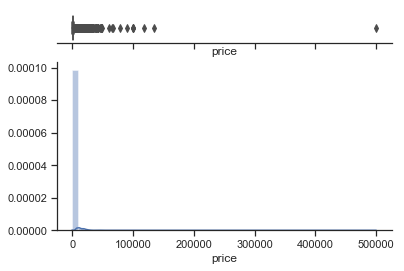

In [85]:
## Distribution and box plot of the raw data with outliers
distWithBox('price')

We can see from the graph that the distribution is not normal so we have to use interquantile range to cutoff outliers

In [86]:
from numpy import percentile
data=df['price']
q25, q75 = percentile(data, 25), percentile(data, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in data if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
outliers_removed = [x for x in data if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=1045.000, 75th=2195.000, IQR=1150.000
Identified outliers: 4619
Non-outlier observations: 94981


In [87]:
outliers=[] 
data_1=df['price'] 
for item in data_1:
    if item <lower or item>upper:
        outliers.append(item)


In [88]:
x=df['price']
outlier_indices=list(data_1.index[(x<lower) | (x> upper)])

In [89]:
len(outlier_indices)

4619

In [90]:
df.drop(axis=0,index=outlier_indices, inplace=True)

In [91]:
df.shape

(94981, 49)

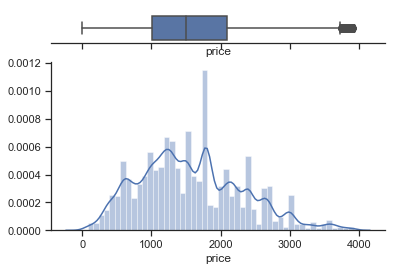

In [92]:
## lets plot distribution with and box plot to see the change after we trim down the outliers
distWithBox('price')

### Label Encoding

In [93]:
df[cat_cols]= df[cat_cols].apply(LabelEncoder().fit_transform)

### Feature Selection


VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

so we can select using the threshold .8 * (1 - .8):

In [94]:
df_X=df.loc[:, df.columns != 'price']
df_y=df['price']

In [95]:
from sklearn.feature_selection import VarianceThreshold
print('%s Number of features before VarianceThreshhold'%len(df_X.columns))

selector=VarianceThreshold(threshold=(.8*(1-.8)))
FeaturesTransformed=selector.fit_transform(df_X)

## print the support and shape of the transformed features
print(selector.get_support())


48 Number of features before VarianceThreshhold
[ True  True False  True False False  True  True  True False False  True
 False False False  True  True  True  True False  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False]


In [96]:
data=df_X[df_X.columns[selector.get_support(indices=True)]]
cols=data.columns

In [97]:
df_reduced=pd.DataFrame(FeaturesTransformed, columns=cols)
df_reduced.shape

(94981, 37)

In [98]:
df_X=df_reduced

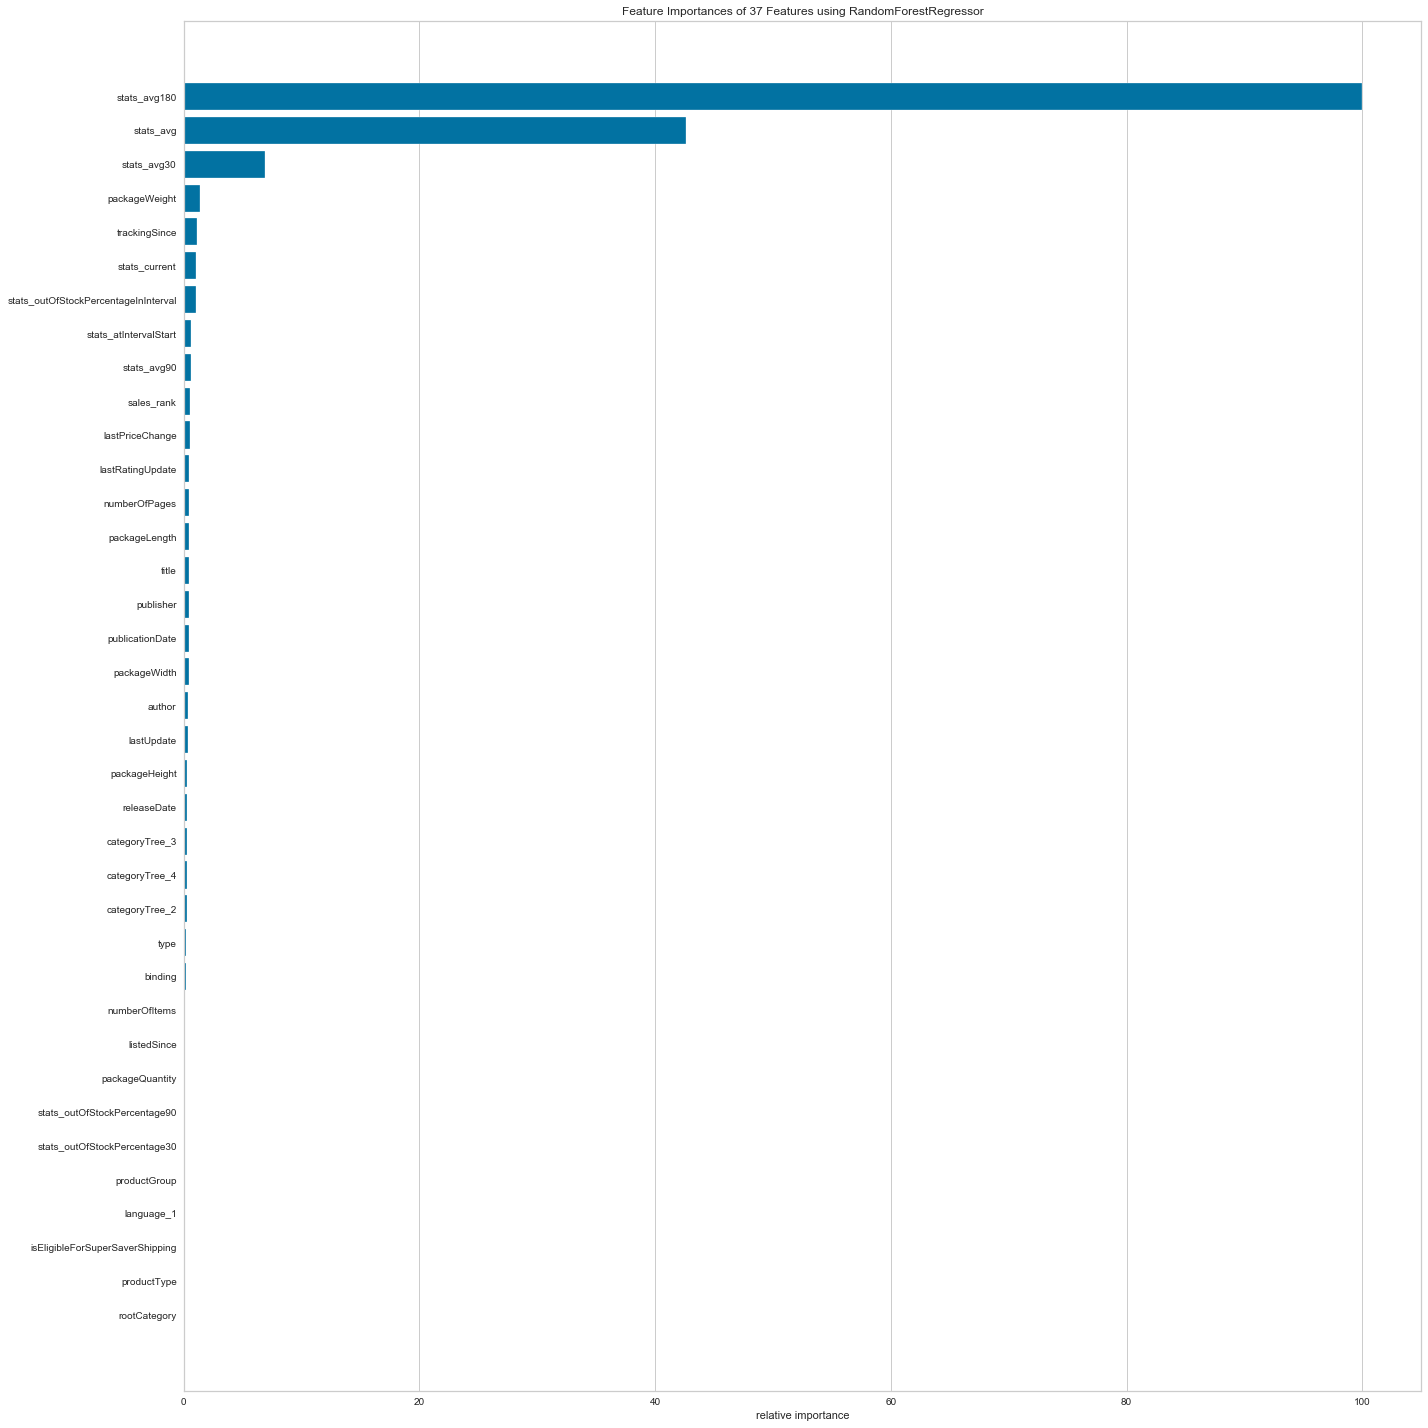

In [99]:
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.features.importances import FeatureImportances

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

viz = FeatureImportances(RandomForestRegressor(), ax=ax)
viz.fit(df_X, df_y)
viz.poof()

In [100]:
feature_importances = pd.DataFrame(viz.feature_importances_,
                                   index=df_X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [101]:
## important features for Random Forest Regression
importants=feature_importances.index[feature_importances.importance!=0]

In [102]:
importants

Index(['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4', 'categoryTree_3',
       'categoryTree_2', 'binding', 'author', 'productType'],
      dtype='object')

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as split
X=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4', 'categoryTree_3',
       'categoryTree_2', 'binding', 'author', 'productType']]
Y=df['price']
model=RandomForestRegressor()
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
model.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

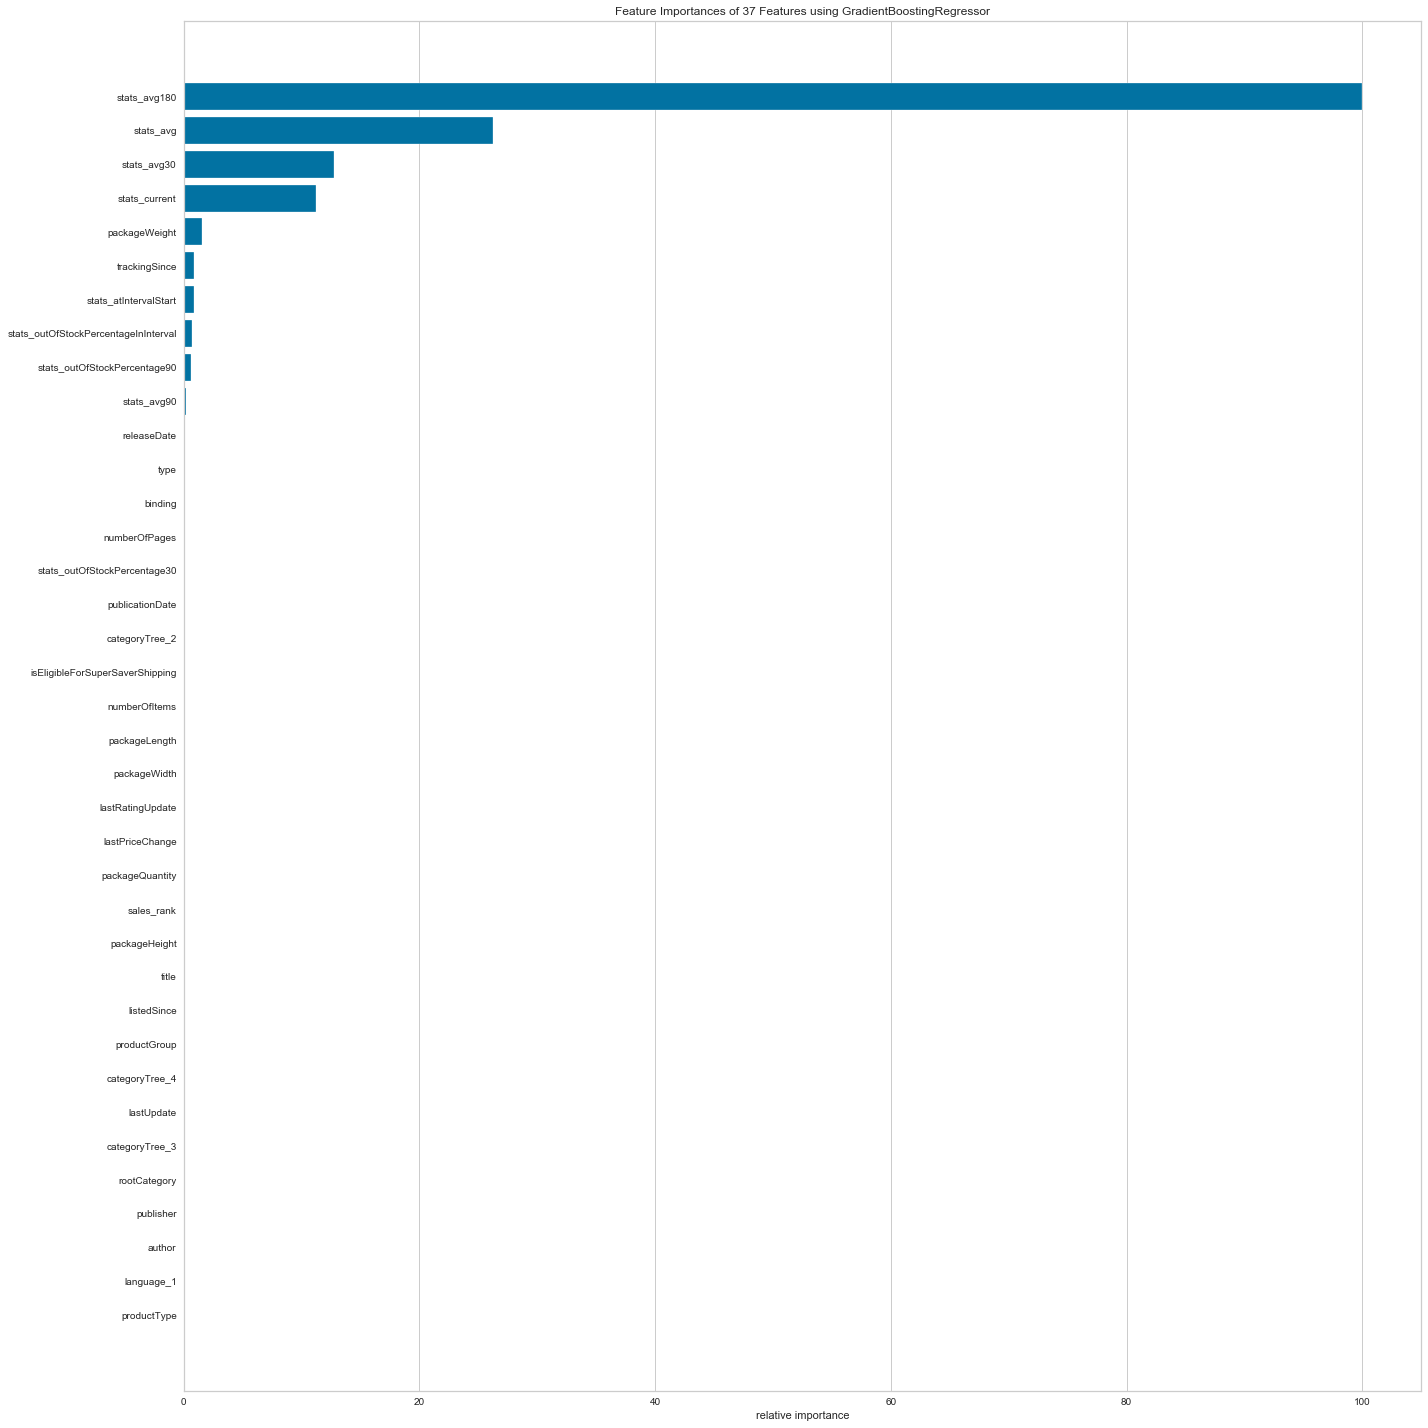

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.features.importances import FeatureImportances

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingRegressor(), ax=ax)
viz.fit(df_X, df_y)
viz.poof()

In [105]:
feature_importances = pd.DataFrame(viz.feature_importances_,
                                   index=df_X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [106]:
## important features for gradient boosting regression
importants=feature_importances.index[feature_importances.importance!=0]

In [107]:
importants

Index(['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4', 'categoryTree_3',
       'categoryTree_2'],
      dtype='object')

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split as split
X=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4']]
Y=df['price']
model=GradientBoostingRegressor()
X_train, X_test, Y_train, Y_test= split(X,Y,test_size=0.25, random_state=42)
model.fit(X_train,Y_train)
prediction1 = model.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction1))
mse = mean_squared_error(Y_test, prediction1)
print("The root mean square value", math.sqrt(mse))





Accuracy Score 0.936166520514486
The root mean square value 187.7335277294575


In [109]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
rfg.fit(X_train, Y_train)
prediction2 = rfg.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction2))
mse2 = mean_squared_error(Y_test, prediction2)
print("The root mean square value", math.sqrt(mse2))


Accuracy Score 0.9345685171063185
The root mean square value 190.0688572560226


In [110]:
from sklearn.tree import DecisionTreeRegressor
dtg = DecisionTreeRegressor()
dtg.fit(X_train, Y_train)
prediction3 = dtg.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction3))
mse3 = mean_squared_error(Y_test, prediction3)
print("The root mean square value", math.sqrt(mse3))

Accuracy Score 0.8801864179554051
The root mean square value 257.1997892220061


In [111]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)
prediction4 = lr.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction4))
mse4 = mean_squared_error(Y_test, prediction4)
print("The root mean square value", math.sqrt(mse4))

Accuracy Score 0.8297900441270708
The root mean square value 306.55617013852


In [112]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, Y_train)
prediction5 = mlp.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction5))
mse5 = mean_squared_error(Y_test, prediction5)
print("The root mean square value", math.sqrt(mse5))

Accuracy Score -855816.7446258086
The root mean square value 687397.9389288455


In [113]:
from sklearn.linear_model import RidgeCV
rcv = RidgeCV()
rcv.fit(X_train, Y_train)
prediction6 = rcv.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction6))
mse6 = mean_squared_error(Y_test, prediction6)
print("The root mean square value", math.sqrt(mse6))

Accuracy Score -5.5668444270296e+39
The root mean square value 5.543985993856586e+22


In [114]:
from sklearn.linear_model import ElasticNet
lm_elastic = ElasticNet()
lm_elastic.fit(X_train, Y_train)
prediction7 = lm_elastic.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction7))
mse7 = mean_squared_error(Y_test, prediction7)
print("The root mean square value", math.sqrt(mse7))

Accuracy Score 0.8501452673150486
The root mean square value 287.64234045030184


In [115]:
from sklearn.linear_model import LassoLars
llrs = LassoLars()
llrs.fit(X_train, Y_train)
prediction8 = llrs.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction8))
mse8 = mean_squared_error(Y_test, prediction8)
print("The root mean square value", math.sqrt(mse8))

Accuracy Score 0.6205168287618223
The root mean square value 457.734706363672


In [116]:
from sklearn.linear_model import Lasso
lass = Lasso()
lass.fit(X_train, Y_train)
prediction9 = lass.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction9))
mse9 = mean_squared_error(Y_test, prediction9)
print("The root mean square value", math.sqrt(mse9))

Accuracy Score 0.8548555946227044
The root mean square value 283.08557013109515


In [117]:
from sklearn.linear_model import BayesianRidge
br = BayesianRidge()
br.fit(X_train, Y_train)
prediction10 = br.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction10))
mse10 = mean_squared_error(Y_test, prediction10)
print("The root mean square value", math.sqrt(mse10))

Accuracy Score -17.537178011584082
The root mean square value 3199.1852764373166


In [118]:
from sklearn import linear_model
ransac = linear_model.RANSACRegressor()
ransac.fit(X_train, Y_train)
prediction11 = ransac.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction11))
mse11 = mean_squared_error(Y_test, prediction11)
print("The root mean square value", math.sqrt(mse11))

Accuracy Score -291352.83824638283
The root mean square value 401077.1812171563


In [119]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train, Y_train)
prediction12 = svr_rbf.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction12))
mse12 = mean_squared_error(Y_test, prediction12)
print("The root mean square value", math.sqrt(mse12))

Accuracy Score -0.011716493134165562
The root mean square value 747.3895085073743


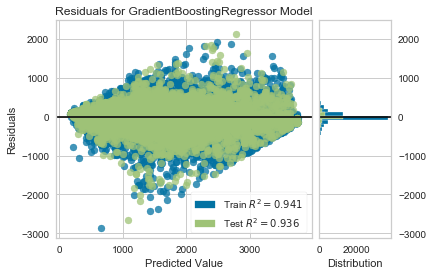

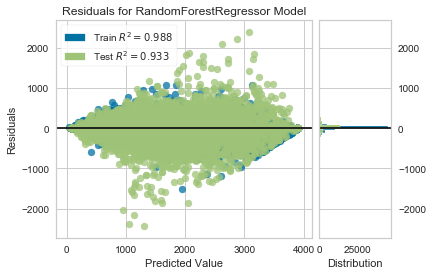

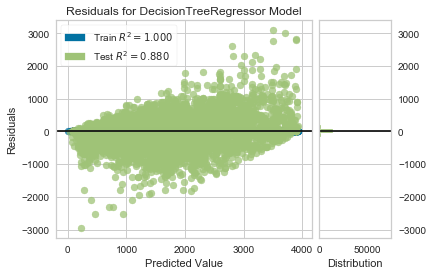

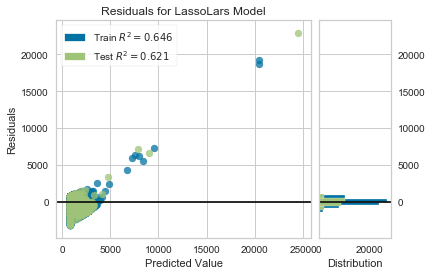

In [120]:
%matplotlib inline
from sklearn.linear_model import LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import ResidualsPlot


regressors = {
    "Gradient Boost": GradientBoostingRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Lasso Lars": LassoLars()
    
    
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, Y_train)
    visualizer.score(X_test, Y_test)
    visualizer.poof()

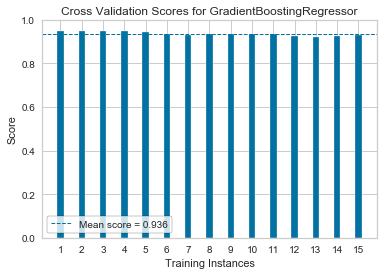

In [121]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from yellowbrick.model_selection import CVScores

ind=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4']].values
dep=df['price'].values

_, ax = plt.subplots()
cv = KFold(15)
oz = CVScores(
    GradientBoostingRegressor(), ax=ax, cv=cv, scoring = 'r2'
)

oz.fit(ind, dep)
oz.poof()


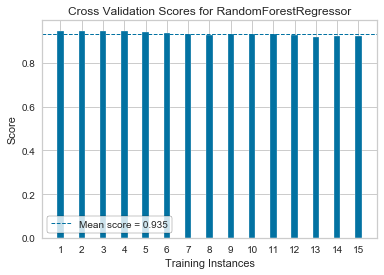

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from yellowbrick.model_selection import CVScores

ind=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4']].values
dep=df['price'].values

_, ax = plt.subplots()
cv = KFold(15)
oz = CVScores(
    RandomForestRegressor(), ax=ax, cv=cv, scoring='r2'
)

oz.fit(ind, dep)
oz.poof()


In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

GradientBoosting = GradientBoostingRegressor(random_state = 40)
alphas = [0.001, 0.01, 0.1, 0.5, 0.9]
sample_split = [2,3,4,5,6,7,8]
max_depth = [4,5,6,7,8,9]
learning_rate = [0.1, 0.3, 0.5, 0.7]
tuned_params = [{'alpha': alphas}, {'min_samples_split': sample_split}, {'max_depth': max_depth}, {'learning_rate':learning_rate}]
n_folds = 5

X=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4']]
Y=df['price']

grid = GridSearchCV(
    GradientBoosting, tuned_params, cv=n_folds
)

grid.fit(X, Y)
print(grid.best_estimator_)




GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

RandomForest = RandomForestRegressor(random_state = 40)

estimators = [10,50,100]
sample_split = [2,3,4,5,6,7,8]
sample_leaf = [1,2,3,4,5]
max_depth = [4,5,6,7,8,9]
tuned_params = [{'n_estimators': estimators}, {'min_samples_split': sample_split}, {'min_samples_leaf': sample_leaf},{'max_leaf_nodes': max_depth}]
n_folds = 5

X=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4']]
Y=df['price']

grid = GridSearchCV(
    RandomForest, tuned_params, cv=n_folds
)

grid.fit(X, Y)
print(grid.best_estimator_)




RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)


In [125]:
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
model.fit(X_train,Y_train)
prediction13 = model.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction13))
mse = mean_squared_error(Y_test, prediction13)
print("The root mean square value", math.sqrt(mse))

Accuracy Score 0.9398133815953722
The root mean square value 182.29197645997385


In [126]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)
rfg.fit(X_train, Y_train)
prediction14 = rfg.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction14))
mse2 = mean_squared_error(Y_test, prediction14)
print("The root mean square value", math.sqrt(mse2))


Accuracy Score 0.9365364496691833
The root mean square value 187.18875862726313


In [127]:
from sklearn.preprocessing import StandardScaler
X=df[['language_1', 'sales_rank', 'type', 'trackingSince', 'title',
       'stats_outOfStockPercentageInInterval', 'stats_outOfStockPercentage90',
       'stats_outOfStockPercentage30', 'stats_current', 'stats_avg180',
       'stats_avg90', 'stats_avg30', 'stats_avg', 'stats_atIntervalStart',
       'rootCategory', 'releaseDate', 'publisher', 'publicationDate',
       'productGroup', 'packageWidth', 'packageWeight', 'packageQuantity',
       'packageLength', 'packageHeight', 'numberOfPages', 'numberOfItems',
       'listedSince', 'lastUpdate', 'lastRatingUpdate', 'lastPriceChange',
       'isEligibleForSuperSaverShipping', 'categoryTree_4', 'categoryTree_3',
       'categoryTree_2', 'binding', 'author', 'productType']]
names = X.columns
scale = StandardScaler()
X_df = scale.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=names)
Y=df['price']
X_df.head(5)


,language_1,sales_rank,type,trackingSince,title,stats_outOfStockPercentageInInterval,stats_outOfStockPercentage90,stats_outOfStockPercentage30,stats_current,stats_avg180,...,lastUpdate,lastRatingUpdate,lastPriceChange,isEligibleForSuperSaverShipping,categoryTree_4,categoryTree_3,categoryTree_2,binding,author,productType
0,-0.089105,-0.227733,1.049109,0.819061,0.170362,2.209466,4.143253,-0.144961,-1.078348,0.550967,...,-0.415624,0.323874,0.256718,-1.03148,0.932973,0.383667,-1.301469,-0.954797,-1.733118,1.042767
1,-0.089105,-0.227779,-0.937757,-0.911137,0.087127,-0.155646,-0.155694,-0.144961,-1.201027,-1.150127,...,-0.446747,0.333766,0.376534,0.96948,-0.769238,-0.182977,-1.003157,-0.645765,0.665084,-0.918443
2,-0.089105,-0.227765,-0.937757,0.497139,0.824169,-0.155646,-0.155694,-0.144961,-0.821605,-0.607597,...,-0.438966,0.333397,0.400202,0.96948,0.028674,1.117728,-0.605408,1.208426,-0.274532,-0.918443
3,-0.089105,-0.227635,-0.937757,0.921278,-0.377151,-0.155646,-0.155694,-0.144961,-0.593952,-0.661267,...,-0.415624,0.334418,0.391626,0.96948,-1.760582,-1.342022,-0.605408,1.208426,-0.792819,-0.918443
4,-0.089105,-0.225168,1.049109,0.724718,-0.001863,-0.155646,-0.155694,-0.144961,1.707876,1.445849,...,-0.423405,0.326802,0.066339,-1.03148,-1.025536,-0.273125,0.289528,-0.954797,0.241315,1.042767


In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df,Y, test_size = 0.25, random_state = 42)
modelScale=GradientBoostingRegressor()
modelScale.fit(X_train,y_train)
predictionScale = modelScale.predict(X_test)
print("Accuracy Score", r2_score(y_test, predictionScale))
mseScale = mean_squared_error(y_test, predictionScale)
print("The root mean square value", math.sqrt(mseScale))


Accuracy Score 0.9367932102141272
The root mean square value 186.80971113495258


In [129]:
from sklearn.ensemble import RandomForestRegressor
rfgScale = RandomForestRegressor()
rfgScale.fit(X_train, y_train)
predictionrfg = rfgScale.predict(X_test)
print("Accuracy Score", r2_score(y_test, predictionrfg))
mseSca = mean_squared_error(y_test, predictionrfg)
print("The root mean square value", math.sqrt(mseSca))


Accuracy Score 0.9351969725659264
The root mean square value 189.15386943970367


In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

GradientBoosting = GradientBoostingRegressor(random_state = 40)
alphas = [0.001, 0.01, 0.1, 0.5, 0.9]
sample_split = [2,3,4,5,6,7,8]
max_depth = [4,5,6,7,8,9]
learning_rate = [0.1, 0.3, 0.5, 0.7]
tuned_params = [{'alpha': alphas}, {'min_samples_split': sample_split}, {'max_depth': max_depth}, {'learning_rate':learning_rate}]
n_folds = 5


grid = GridSearchCV(
    GradientBoosting, tuned_params, cv=n_folds
)

grid.fit(X_df, Y)
print(grid.best_estimator_)




GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


In [131]:
from sklearn.ensemble import GradientBoostingRegressor
modelS=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
modelS.fit(X_train,Y_train)
predictionS1 = modelS.predict(X_test)
print("Accuracy Score", r2_score(Y_test, predictionS1))
mse = mean_squared_error(Y_test, predictionS1)
print("The root mean square value", math.sqrt(mse))

Accuracy Score 0.9401255625926006
The root mean square value 181.81859817070074


In [132]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=40, verbose=0, warm_start=False)
rfg.fit(X_train, Y_train)
prediction14 = rfg.predict(X_test)
print("Accuracy Score", r2_score(Y_test, prediction14))
mse2 = mean_squared_error(Y_test, prediction14)
print("The root mean square value", math.sqrt(mse2))


Accuracy Score 0.9366267038680943
The root mean square value 187.05560674509564


In [133]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def ModelScores(data,target):
    X = data
    Y=target
    from sklearn.model_selection import train_test_split as split
    X_train, X_test, Y_train, Y_test= split(X_df,Y,test_size=0.25, random_state=40)
    
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.neural_network import MLPRegressor
    from sklearn.linear_model import RidgeCV
    from sklearn.linear_model import LassoLars
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.svm import SVR
    from sklearn.linear_model import BayesianRidge
    from sklearn.linear_model import RANSACRegressor

    models={'Gradient Boost': GradientBoostingRegressor(),
            'Random Forest': RandomForestRegressor(),
            'Decision Tree': DecisionTreeRegressor(),
            'Linear Regression': LinearRegression(),
            'MLP': MLPRegressor(),
            'Ridge CV': RidgeCV(),
            'LassoLars':LassoLars(),
            'Lasso':Lasso(),
            'Elastic Search': ElasticNet(),
            'Bayesian Ridge':BayesianRidge(),
            'Ransac':RANSACRegressor()      
           }
    for name,model in models.items():
        mdl=model
        mdl.fit(X_train, Y_train)
        prediction = mdl.predict(X_test)
        print(name)
        print("Accuracy Score", r2_score(Y_test, prediction))
        mse3 = mean_squared_error(Y_test, prediction)
        print("The root mean square value", math.sqrt(mse3))

In [134]:
ModelScores(X_df,Y)

Gradient Boost
Accuracy Score 0.9363677430878624
The root mean square value 187.60809515527353
Random Forest
Accuracy Score 0.9337095307818264
The root mean square value 191.486630406297
Decision Tree
Accuracy Score 0.8812256112045287
The root mean square value 256.31517111127215
Linear Regression
Accuracy Score 0.8668428252853707
The root mean square value 271.3908469328844
MLP
Accuracy Score 0.9290260086727772
The root mean square value 198.1356048238386
Ridge CV
Accuracy Score 0.8669608627624866
The root mean square value 271.27053275034564
LassoLars
Accuracy Score 0.6359800013831245
The root mean square value 448.72010873273285
Lasso
Accuracy Score 0.8730969207892616
The root mean square value 264.94088972648507
Elastic Search
Accuracy Score 0.8424282877866276
The root mean square value 295.22425647076284
Bayesian Ridge
Accuracy Score 0.8669602566941127
The root mean square value 271.2711506448496
Ransac
Accuracy Score -2.582049689439989e+20
The root mean square value 1195075128843

In [135]:
from sklearn.decomposition import PCA
pca = PCA()
X = pca.fit_transform(X_df)
exp_variance = pca.explained_variance_ratio_
print(exp_variance)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 40)
from sklearn.ensemble import GradientBoostingRegressor
modelS=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=40, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
modelS.fit(X_train,Y_train)
predictionS1 = modelS.predict(X_test)
print("Accuracy Score", r2_score(Y_test, predictionS1))
mse = mean_squared_error(Y_test, predictionS1)
print("The root mean square value", math.sqrt(mse))

[2.64089811e-01 1.33347693e-01 8.74779248e-02 3.71342098e-02
 3.00158716e-02 2.85265644e-02 2.79891570e-02 2.71173766e-02
 2.69522094e-02 2.68891066e-02 2.64068270e-02 2.61079369e-02
 2.56749961e-02 2.55578893e-02 2.48376914e-02 2.34310623e-02
 2.27857499e-02 2.13663066e-02 1.97996837e-02 1.83007131e-02
 1.66211202e-02 1.42005906e-02 1.11698379e-02 9.01006757e-03
 6.22404654e-03 5.30523640e-03 3.43552165e-03 2.35637720e-03
 1.96343025e-03 1.76120747e-03 1.36246293e-03 1.09939634e-03
 4.97719030e-04 4.20423923e-04 3.90835138e-04 3.20459894e-04
 5.24860289e-05]
Accuracy Score 0.9314405237362803
The root mean square value 194.7361842743379


After applying the PCA the accuracy score of the model had decreased and the error rate had increased. That's why we are going with Standardized data.